# Image Completion Transformer(ICT)

## ICT基本原理

图像补全（又称图像修复）旨在用视觉上逼真和语义上适当的内容来填充图像的缺失部分，被广泛应用于图像处理领域。卷积神经网络由于其强大的纹理建模能力，在计算机视觉领域取得了巨大进展，然而卷积神经网络在理解全局结构上表现不佳，近几年transformer的发展证明了其在建模长期关系（全局结构）方面的能力，但transformer的计算复杂度阻碍了其在处理高分辨率图像中的应用。ICT将这两种方法的优点结合到图像补全任务当中，先使用transformer进行外观先验重建，恢复了多元相干结构和一些粗糙纹理，再用卷积神经网络进行纹理补充，增强了由高分辨率掩模图像引导的粗糙先验的局部纹理细节，其基本原理如下图所示。
<div align=center>
<img src="./images/model.jpg"/>
</div>

## ImageNet数据集

在下面的教程中，我们将通过示例代码说明如何设置网络、优化器、以及计算损失函数。在本教程中，我们使用ImageNet数据集进行训练与推理，可自行前往[ImageNet数据集官网](https://image-net.org/)进行下载，解压后使文件呈如下目录结构：

```text
# ImageNet dataset
.imagenet/
├── train/  (1000 directories and 1281167 images)
   ├── n04347754/
   │   ├── 000001.jpg
   │   ├── 000002.jpg
   │   └── ....
   └── n04347756/
       ├── 000001.jpg
       ├── 000002.jpg
       └── ....
├── val/  (1000 directories and 50000 images)
   ├── n04347754/
   │   ├── 000001.jpg
   │   ├── 000002.jpg
   │   └── ....
   └── n04347756/
       ├── 000001.jpg
       ├── 000002.jpg
       └── ....
```

## Mask掩码数据集

在图像补全任务中，我们还需要掩码数据集来对图像进行mask处理，以得到部分像素损坏的图像，[掩码数据集](https://www.dropbox.com/s/01dfayns9s0kevy/test_mask.zip?dl=0)可自行前往下载，解压后使文件呈如下目录结构：

```text
# Mask dataset
.mask/
├── testing_mask_dataset/
   ├── 000001.png
   ├── 000002.png
   ├── 000003.png
   └── ....
```

## 参数设置

首先设置训练与推理相关参数，并选择执行模式，本案例默认使用动态图运行模式进行推理与训练。
值得注意的是，在训练阶段依赖VGG19的模型，权重文件[VGG19.ckpt](https://download.mindspore.cn/vision/ict/VGG19.ckpt)需要提前进行下载，并在参数中保持地址一致。

In [1]:
import os
import argparse

import mindspore
import numpy as np

from mindspore import context


def parse_args():
    """Parse args."""
    parser = argparse.ArgumentParser()
    # Parameter of train
    parser.add_argument('--data_path', type=str, default='/data0/imagenet2012/train',
                        help='Indicate where is the training set')
    parser.add_argument('--mask_path', type=str, default='/home/ict/ICT/mask/testing_mask_dataset',
                        help='Where is the mask')
    parser.add_argument('--n_layer', type=int, default=35)
    parser.add_argument('--n_head', type=int, default=8)
    parser.add_argument('--n_embd', type=int, default=1024)
    parser.add_argument('--GELU_2', action='store_true', help='use the new activation function')
    parser.add_argument('--use_ImageFolder', action='store_true', help='Using the original folder for ImageNet dataset')
    parser.add_argument('--random_stroke', action='store_true', help='Use the generated mask')
    parser.add_argument('--train_epoch', type=int, default=5, help='How many epochs')
    parser.add_argument('--learning_rate', type=float, default=3e-4, help='Value of learning rate.')
    parser.add_argument('--input', type=str, default='/data0/imagenet2012/train',
                        help='path to the input images directory or an input image')
    parser.add_argument('--mask', type=str, default='/home/ict/ICT/mask/testing_mask_dataset',
                        help='path to the masks directory or a mask file')
    parser.add_argument('--prior', type=str, default='', help='path to the edges directory or an edge file')
    parser.add_argument('--kmeans', type=str, default='../kmeans_centers.npy', help='path to the kmeans')
    # 根据VGG19.ckpt的路径，要进行相应修改，VGG19权重文件可在推理部分给出的权重地址进行下载
    parser.add_argument('--vgg_path', type=str, default='../ckpts_ICT/VGG19.ckpt', help='path to the VGG')
    parser.add_argument('--image_size', type=int, default=256, help='the size of origin image')
    parser.add_argument('--prior_random_degree', type=int, default=1, help='during training, how far deviate from')
    parser.add_argument('--use_degradation_2', action='store_true', help='use the new degradation function')
    parser.add_argument('--mode', type=int, default=1, help='1:train, 2:test')
    parser.add_argument('--mask_type', type=int, default=2)
    parser.add_argument('--max_iteration', type=int, default=25000, help='How many run iteration')
    parser.add_argument('--lr', type=float, default=0.0001, help='Value of learning rate.')
    parser.add_argument('--D2G_lr', type=float, default=0.1,
                        help='Value of discriminator/generator learning rate ratio')
    parser.add_argument("--l1_loss_weight", type=float, default=1.0)
    parser.add_argument("--style_loss_weight", type=float, default=250.0)
    parser.add_argument("--content_loss_weight", type=float, default=0.1)
    parser.add_argument("--inpaint_adv_loss_weight", type=float, default=0.1)
    parser.add_argument('--ckpt_path', type=str, default='', help='model checkpoints path')
    parser.add_argument('--save_path', type=str, default='./checkpoint', help='save checkpoints path')
    parser.add_argument('--device_id', type=int, default='0')
    parser.add_argument('--device_target', type=str, default='GPU', help='GPU or Ascend')
    parser.add_argument('--prior_size', type=int, default=32, help='Input sequence length = prior_size*prior_size')
    parser.add_argument('--batch_size', type=int, default=2, help='The number of train batch size')
    parser.add_argument("--beta1", type=float, default=0.9, help="Value of beta1")
    parser.add_argument("--beta2", type=float, default=0.95, help="Value of beta2")

    # Parameter of infer
    parser.add_argument('--image_url', type=str, default='/data0/imagenet2012/val', help='the folder of image')
    parser.add_argument('--mask_url', type=str, default='/home/ict/ICT/mask/testing_mask_dataset',
                        help='the folder of mask')
    parser.add_argument('--top_k', type=int, default=40)
    parser.add_argument('--save_url', type=str, default='./sample', help='save the output results')
    parser.add_argument('--condition_num', type=int, default=1, help='Use how many BERT output')
    args = parser.parse_known_args()[0]
    return args


# 选择执行模式为动态图模式，执行硬件平台为GPU
context.set_context(mode=context.PYNATIVE_MODE, device_target='GPU')
opts = parse_args()


## 训练

### Transformer训练

#### Transformer网络结构

由于Transformer计算量偏大，因此在图片输入网络前会先对其进行下采样，在ImageNet数据中，图片会被采样到32*32分辨率，以得到图像低分辨率的图像先验信息，Transformer的结构如下所示：

<div align=center>
<img src="./images/transformer.jpg"/>
</div>

以下是Transformer的代码实现：

In [2]:
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.ops.operations as P
from mindspore import Tensor
from mindspore.common.initializer import Normal


class CausalSelfAttention(nn.Cell):
    """
    The CausalSelfAttention part of transformer.

    Args:
        n_embd (int): The size of the vector space in which words are embedded.
        n_head (int): The number of multi-head.
        block_size (int): The context size(Input sequence length).
        resid_pdrop (float): The probability of resid_pdrop. Default: 0.1
        attn_pdrop (float): The probability of attn_pdrop. Default: 0.1

    Returns:
        Tensor, output tensor.
    """

    def __init__(self, n_embd: int, n_head: int, block_size: int, resid_pdrop: float = 0.1, attn_pdrop: float = 0.1):
        super().__init__()
        # key, query, value projections for all heads
        self.key = nn.Dense(in_channels=n_embd, out_channels=n_embd,
                            weight_init=Normal(sigma=0.02, mean=0.0))
        self.query = nn.Dense(in_channels=n_embd, out_channels=n_embd,
                              weight_init=Normal(sigma=0.02, mean=0.0))
        self.value = nn.Dense(in_channels=n_embd, out_channels=n_embd,
                              weight_init=Normal(sigma=0.02, mean=0.0))
        # regularization
        self.attn_drop = nn.Dropout(keep_prob=1.0 - attn_pdrop)
        self.resid_drop = nn.Dropout(keep_prob=1.0 - resid_pdrop)
        # output projection
        self.proj = nn.Dense(in_channels=n_embd, out_channels=n_embd,
                             weight_init=Normal(sigma=0.02, mean=0.0))

        tril = nn.Tril()
        self.mask = mindspore.Parameter(
            tril(P.Ones()((block_size, block_size), mindspore.float32)).view(1, 1, block_size, block_size),
            requires_grad=False)

        self.n_head = n_head

    def construct(self, x):
        B, T, C = P.Shape()(x)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head)
        k = k.transpose(0, 2, 1, 3)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head)
        q = q.transpose(0, 2, 1, 3)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head)
        v = v.transpose(0, 2, 1, 3)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        k_shape = k.shape[-1]
        sz = 1.0 / (Tensor(k_shape) ** Tensor(0.5))
        q = mindspore.ops.Cast()(q, mindspore.float16)
        k = mindspore.ops.Cast()(k, mindspore.float16)
        sz = mindspore.ops.Cast()(sz, mindspore.float16)
        att = (ops.matmul(q, k.transpose(0, 1, 3, 2)) * sz)
        att = mindspore.ops.Cast()(att, mindspore.float32)
        att = P.Softmax()(att)
        att = self.attn_drop(att)
        att = mindspore.ops.Cast()(att, mindspore.float16)
        v = mindspore.ops.Cast()(v, mindspore.float16)
        y = mindspore.ops.matmul(att, v)
        y = mindspore.ops.Cast()(y, mindspore.float32)
        y = y.transpose(0, 2, 1, 3).view(B, T, C)  # re-assemble all head outputs side by side
        # output projection
        y = self.resid_drop(self.proj(y))
        return y


class GELU2(nn.Cell):
    """
    The new gelu2 activation function.

    Returns:
        Tensor, output tensor.
    """

    def construct(self, x):
        return x * P.Sigmoid()(1.702 * x)


class Block_2(nn.Cell):
    """
    Transformer block with original GELU2.

    Args:
        n_embd (int): The size of the vector space in which words are embedded.
        n_head (int): The number of multi-head.
        block_size (int): The context size(Input sequence length).
        resid_pdrop (float): The probability of resid_pdrop. Default: 0.1
        attn_pdrop (float): The probability of attn_pdrop. Default: 0.1

    Returns:
        Tensor, output tensor.
    """

    def __init__(self, n_embd: int, n_head: int, block_size: int, resid_pdrop: float = 0.1, attn_pdrop: float = 0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(normalized_shape=[n_embd], epsilon=1e-05)
        self.ln2 = nn.LayerNorm(normalized_shape=[n_embd], epsilon=1e-05)
        self.attn = CausalSelfAttention(n_embd, n_head, block_size, resid_pdrop, attn_pdrop)
        self.mlp = nn.SequentialCell([
            nn.Dense(in_channels=n_embd, out_channels=4 * n_embd,
                     weight_init=Normal(sigma=0.02, mean=0.0)),
            GELU2(),
            nn.Dense(in_channels=4 * n_embd, out_channels=n_embd,
                     weight_init=Normal(sigma=0.02, mean=0.0)),
            nn.Dropout(keep_prob=1.0 - resid_pdrop),
        ])

    def construct(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class Block(nn.Cell):
    """
    Transformer block with original GELU.

    Args:
        n_embd (int): The size of the vector space in which words are embedded.
        n_head (int): The number of multi-head.
        block_size (int): The context size(Input sequence length).
        resid_pdrop (float): The probability of resid_pdrop. Default: 0.1
        attn_pdrop (float): The probability of attn_pdrop. Default: 0.1

    Returns:
        Tensor, output tensor.
    """

    def __init__(self, n_embd: int, n_head: int, block_size: int, resid_pdrop: float = 0.1, attn_pdrop: float = 0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(normalized_shape=[n_embd], epsilon=1e-05)
        self.ln2 = nn.LayerNorm(normalized_shape=[n_embd], epsilon=1e-05)
        self.attn = CausalSelfAttention(n_embd, n_head, block_size, resid_pdrop, attn_pdrop)
        self.mlp = nn.SequentialCell([
            nn.Dense(in_channels=n_embd, out_channels=4 * n_embd,
                     weight_init=Normal(sigma=0.02, mean=0.0)),
            nn.GELU(),
            nn.Dense(in_channels=4 * n_embd, out_channels=n_embd,
                     weight_init=Normal(sigma=0.02, mean=0.0)),
            nn.Dropout(keep_prob=1.0 - resid_pdrop),
        ])

    def construct(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class GPT(nn.Cell):
    """
    The full GPT language model, with a context size of block_size.

    Args:
        vocab_size (int): The size of the vocabulary in the embedded data.
        n_embd (int): The size of the vector space in which words are embedded.
        n_layer (int): The number of attention layer.
        n_head (int): The number of multi-head.
        block_size (int): The context size(Input sequence length).
        use_gelu2 (bool): Use the new gelu2 activation function.
        embd_pdrop (float): The probability of embd_pdrop. Default: 0.1
        resid_pdrop (float): The probability of resid_pdrop. Default: 0.1
        attn_pdrop (float): The probability of attn_pdrop. Default: 0.1

    Returns:
        Tensor, output tensor.
    """

    def __init__(self, vocab_size: int, n_embd: int, n_layer: int, n_head: int, block_size: int, use_gelu2: bool,
                 embd_pdrop: float = 0.1, resid_pdrop: float = 0.1, attn_pdrop: float = 0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd, embedding_table=Normal(sigma=0.02, mean=0.0))
        self.pos_emb = mindspore.Parameter(P.Zeros()((1, block_size, n_embd), mindspore.float32))
        self.drop = nn.Dropout(keep_prob=1.0 - embd_pdrop)
        # transformer
        if use_gelu2:
            self.blocks = nn.SequentialCell(
                [*[Block_2(n_embd, n_head, block_size, resid_pdrop, attn_pdrop) for _ in range(n_layer)]])
        else:
            self.blocks = nn.SequentialCell(
                [*[Block(n_embd, n_head, block_size, resid_pdrop, attn_pdrop) for _ in range(n_layer)]])
        # decoder head
        self.ln_f = nn.LayerNorm(normalized_shape=[n_embd], epsilon=1e-05)
        self.head = nn.Dense(in_channels=n_embd, out_channels=vocab_size, has_bias=False,
                             weight_init=Normal(sigma=0.02, mean=0.0))

        self.block_size = block_size

    def get_block_size(self):
        return self.block_size

    def construct(self, idx, masks):
        _, t = idx.shape
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector
        masks = P.ExpandDims()(masks, 2)
        token_embeddings = token_embeddings * (1 - masks)
        position_embeddings = self.pos_emb[:, :t, :]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits


#### 定义损失函数

In [3]:
class TransformerWithLoss(nn.Cell):
    """
    Wrap the network with loss function to return Transformer with loss.

    Args:
        backbone (Cell): The target network to wrap.
    """

    def __init__(self, backbone):
        super(TransformerWithLoss, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True)

    def construct(self, x, targets, masks):
        logits = self.backbone(x, masks)
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), targets.view(-1))
        masks = P.ExpandDims()(masks, 2)
        masks = masks.view(-1)
        loss *= masks
        loss = P.ReduceMean()(loss)
        return loss


#### 定义数据集以及模型

In [4]:
# 修改当前路径至ICT/Transformer
if os.getcwd().endswith('ICT') or os.getcwd().endswith('ict'):
    os.chdir("./Transformer")

# 启动ImageNet数据集选项
opts.use_ImageFolder = True

from datasets.dataset import load_dataset
from transformer_utils.util import AverageMeter

kmeans = np.load('../kmeans_centers.npy')
kmeans = np.rint(127.5 * (kmeans + 1.0))

# Define the dataset
train_dataset = load_dataset(opts.data_path, kmeans, mask_path=opts.mask_path, is_train=True,
                             use_imagefolder=opts.use_ImageFolder, prior_size=opts.prior_size,
                             random_stroke=opts.random_stroke)
train_dataset = train_dataset.batch(opts.batch_size)
step_size = train_dataset.get_dataset_size()

# Define the model
block_size = opts.prior_size * opts.prior_size
transformer = GPT(vocab_size=kmeans.shape[0], n_embd=opts.n_embd, n_layer=opts.n_layer, n_head=opts.n_head,
                  block_size=block_size, use_gelu2=opts.GELU_2, embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0)
model = TransformerWithLoss(backbone=transformer)

# Define the optimizer
optimizer = nn.Adam(model.trainable_params(), learning_rate=opts.learning_rate, beta1=opts.beta1, beta2=opts.beta2)

train_net = nn.TrainOneStepCell(model, optimizer)


# Mask is 12000, # Image is 1281167


现在，可以开始进行Transformer模块的训练，但由于训练时间过长，在案例中设置了跑100个step后退出训练。

In [5]:
train_loss = AverageMeter()
best_loss = 10000000000.
if not os.path.exists(opts.save_path):
    os.mkdir(opts.save_path)
opts.train_epoch = 1
for epoch in range(opts.train_epoch):
    train_loss.reset()
    for i, sample in enumerate(train_dataset.create_dict_iterator()):
        x = sample['data']
        y = sample['mask']
        y = mindspore.ops.Cast()(y, mindspore.float32)
        loss = train_net(x, x, y)
        train_loss.update(loss, 1)
        if i % 2 == 0:
            print(f"Epoch: [{epoch} / {opts.train_epoch}], "
                  f"step: [{i} / {step_size}], "
                  f"loss: {train_loss.avg}")
            if train_loss.avg < best_loss:
                best_loss = train_loss.avg
                mindspore.save_checkpoint(transformer, os.path.join(opts.save_path, 'ImageNet_best.ckpt'))
        if i != 0 and i % 100 == 0:
            break

mindspore.save_checkpoint(transformer, os.path.join(opts.save_path, 'ImageNet_latest.ckpt'))


Epoch: [0 / 1], step: [0 / 640584], loss: 2.3461065
Epoch: [0 / 1], step: [2 / 640584], loss: 1.9187536
Epoch: [0 / 1], step: [4 / 640584], loss: 2.2250066
Epoch: [0 / 1], step: [6 / 640584], loss: 2.012975
Epoch: [0 / 1], step: [8 / 640584], loss: 1.9185004
Epoch: [0 / 1], step: [10 / 640584], loss: 2.029932
Epoch: [0 / 1], step: [12 / 640584], loss: 1.8645165
Epoch: [0 / 1], step: [14 / 640584], loss: 1.8122841
Epoch: [0 / 1], step: [16 / 640584], loss: 1.839644
Epoch: [0 / 1], step: [18 / 640584], loss: 1.8506514
Epoch: [0 / 1], step: [20 / 640584], loss: 1.8468419
Epoch: [0 / 1], step: [22 / 640584], loss: 1.8536526
Epoch: [0 / 1], step: [24 / 640584], loss: 1.8307922
Epoch: [0 / 1], step: [26 / 640584], loss: 1.8683892
Epoch: [0 / 1], step: [28 / 640584], loss: 1.8084791
Epoch: [0 / 1], step: [30 / 640584], loss: 1.7744089
Epoch: [0 / 1], step: [32 / 640584], loss: 1.7563615
Epoch: [0 / 1], step: [34 / 640584], loss: 1.823318
Epoch: [0 / 1], step: [36 / 640584], loss: 1.867663
Epo

### Upsample训练

在得到低维图像重建先验后，我们需要学习一个确定性映射将其重新缩放为原始分辨率，由于卷积神经网络在建模纹理方面具有优势，我们引入了一种基于卷积神经网络的引导上采样网络，它可以在掩码输入的指导下渲染重建的外观先验的高保真细节，引导上采样网络的处理可以描述为下式：

$$I_{pred} = F_{\delta}(I_{t}^{\uparrow} \cap I_{m}) \in \mathbb{R}^{H * W * 3}$$

其中$I_{t}^{\uparrow}$表示的是Transformer得到的先验图像信息经过双线性插值到原来图像尺寸的结果，$\cap$ 代表的是concat操作，F则是由$\delta$参数化的上采样网络主干。

#### Upsample网络结构

##### 生成器

上采样主干网络主要由编码器、解码器和几个residual blocks组成，上采样网络结构如下图所示：
<div align=center>
<img src="./images/generator.jpg"/>
</div>
上采样网络生成器代码实现如下：

In [6]:
class Generator(nn.Cell):
    def __init__(self, residual_blocks=8):
        super(Generator, self).__init__()

        self.encoder = nn.SequentialCell(
            nn.Pad(((0, 0), (0, 0), (3, 3), (3, 3)), mode='REFLECT'),
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=7, pad_mode='pad', padding=0, has_bias=True),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad_mode='pad', padding=1,
                      has_bias=True),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad_mode='pad', padding=1,
                      has_bias=True),
            nn.ReLU()
        )

        blocks = []
        for _ in range(residual_blocks):
            block = ResnetBlock_remove_IN(256, 2)
            blocks.append(block)
        self.middle = nn.SequentialCell(*blocks)
        self.decoder = nn.SequentialCell(
            nn.Conv2dTranspose(in_channels=256, out_channels=128, kernel_size=4, stride=2, pad_mode='pad', padding=1,
                               has_bias=True),
            nn.ReLU(),

            nn.Conv2dTranspose(in_channels=128, out_channels=64, kernel_size=4, stride=2, pad_mode='pad', padding=1,
                               has_bias=True),
            nn.ReLU(),

            nn.Pad(((0, 0), (0, 0), (3, 3), (3, 3)), mode='REFLECT'),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, pad_mode='pad', padding=0, has_bias=True),
        )

    def construct(self, images, edges, masks):
        images_masked = (images * P.Cast()((1 - masks), mindspore.float32)) + masks
        x = P.Concat(axis=1)((images_masked, edges))
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = (P.Tanh()(x) + 1) / 2

        return x


class ResnetBlock_remove_IN(nn.Cell):
    def __init__(self, dim, dilation=1):
        super(ResnetBlock_remove_IN, self).__init__()
        self.conv_block = nn.SequentialCell([
            nn.Pad(((0, 0), (0, 0), (dilation, dilation), (dilation, dilation)), mode='REFLECT'),
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, pad_mode='pad', dilation=dilation,
                      has_bias=True),
            nn.ReLU(),

            nn.Pad(((0, 0), (0, 0), (1, 1), (1, 1)), mode='SYMMETRIC'),
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, pad_mode='pad', dilation=1, has_bias=True)
        ])

    def construct(self, x):
        out = x + self.conv_block(x)
        return out


##### 鉴别器

为了生成更加真实的细节，我们将鉴别器加入网络训练中，添加了额外的对抗损失，其结构如下图所示：
<div align=center>
<img src="./images/discriminator.jpg"/>
</div>
鉴别器的代码实现如下：

In [7]:
class Discriminator(nn.Cell):
    def __init__(self, in_channels, use_sigmoid=True):
        super(Discriminator, self).__init__()
        self.use_sigmoid = use_sigmoid

        self.conv1 = nn.SequentialCell(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, pad_mode='pad', padding=1),
            nn.LeakyReLU()
        )

        self.conv2 = nn.SequentialCell(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad_mode='pad', padding=1),
            nn.LeakyReLU()
        )

        self.conv3 = nn.SequentialCell(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad_mode='pad', padding=1),
            nn.LeakyReLU()
        )

        self.conv4 = nn.SequentialCell(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, pad_mode='pad', padding=1),
            nn.LeakyReLU()
        )

        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, pad_mode='pad', padding=1)

    def construct(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        outputs = conv5
        if self.use_sigmoid:
            outputs = P.Sigmoid()(conv5)

        return outputs, [conv1, conv2, conv3, conv4, conv5]


#### 定义数据集与网络模型

In [8]:
# 修改当前路径至ICT/Guided_Upsample
if os.getcwd().endswith('Transformer'):
    os.chdir("../Guided_Upsample")
elif os.getcwd().endswith('ICT') or os.getcwd().endswith('ict'):
    os.chdir("./Guided_Upsample")

from Guided_Upsample.datasets.dataset import load_dataset
from Guided_Upsample.models.loss import GeneratorWithLoss, DiscriminatorWithLoss

train_dataset = load_dataset(image_flist=opts.input, edge_flist=opts.prior, mask_filst=opts.mask,
                             image_size=opts.image_size, prior_size=opts.prior_size, mask_type=opts.mask_type,
                             kmeans=opts.kmeans, use_degradation_2=opts.use_degradation_2,
                             prior_random_degree=opts.prior_random_degree,
                             augment=True, training=True)
train_dataset = train_dataset.batch(opts.batch_size)
step_size = train_dataset.get_dataset_size()

generator = Generator()
discriminator = Discriminator(in_channels=3)
model_G = GeneratorWithLoss(generator, discriminator, opts.vgg_path, opts.inpaint_adv_loss_weight, opts.l1_loss_weight,
                            opts.content_loss_weight, opts.style_loss_weight)
model_D = DiscriminatorWithLoss(generator, discriminator)


#### 定义优化器与损失函数

In [9]:
class PSNR(nn.Cell):
    def __init__(self, max_val):
        super(PSNR, self).__init__()

        base10 = P.Log()(mindspore.Tensor(10.0, mindspore.float32))
        max_val = P.Cast()(mindspore.Tensor(max_val), mindspore.float32)

        self.base10 = mindspore.Parameter(base10, requires_grad=False)
        self.max_val = mindspore.Parameter(20 * P.Log()(max_val) / base10, requires_grad=False)

    def __call__(self, a, b):
        a = P.Cast()(a, mindspore.float32)
        b = P.Cast()(b, mindspore.float32)
        mse = P.ReduceMean()((a - b) ** 2)

        if mse == 0:
            return mindspore.Tensor(0)

        return self.max_val - 10 * P.Log()(mse) / self.base10


psnr_func = PSNR(255.0)

# Define the optimizer
optimizer_G = nn.Adam(generator.trainable_params(), learning_rate=opts.lr, beta1=opts.beta1, beta2=opts.beta2)
optimizer_D = nn.Adam(discriminator.trainable_params(), learning_rate=opts.lr * opts.D2G_lr, beta1=opts.beta1,
                      beta2=opts.beta2)


[WARNING] KERNEL(3343840,7f45bcf13680,python):2022-11-03-10:48:17.932.151 [mindspore/ccsrc/plugin/device/gpu/kernel/cuda_impl/cuda_class/cuda_class_common.h:55] CalShapesSizeInBytes] For 'Log', the shapes[0] is ( )


现在，可以开始进行Upsample模块的训练，与上面相似，在案例中设置了跑100个step后退出训练。

In [10]:
from Guided_Upsample.models.loss import TrainOneStepCell
from Guided_Upsample.upsample_utils.util import postprocess

train_net = TrainOneStepCell(model_G, model_D, optimizer_G, optimizer_D)
epoch = 0
iteration = 0
keep_training = True
psnr = AverageMeter()
mae = AverageMeter()
psnr_best = 0.0
opts.max_iteration = 100
if not os.path.exists(opts.save_path):
    os.mkdir(opts.save_path)
while keep_training:
    epoch += 1
    for i, sample in enumerate(train_dataset.create_dict_iterator()):
        images = sample['images']
        edges = sample['edges']
        masks = sample['masks']
        loss_D, loss_G = train_net(images, edges, masks)
        iteration += 1
        if i % 2 == 0:
            outputs = generator(images, edges, masks)
            outputs_merged = (outputs * masks) + (images * (1 - masks))
            psnr.update(psnr_func(postprocess(images), postprocess(outputs_merged)), 1)
            mae.update((P.ReduceSum()(P.Abs()(images - outputs_merged)) / P.ReduceSum()(images)), 1)
            print(f"Epoch: [{epoch}], "
                  f"step: [{i} / {step_size}], "
                  f"psnr: {psnr.avg}, mae: {mae.avg}")
            if psnr.avg > psnr_best:
                psnr_best = psnr.avg
                mindspore.save_checkpoint(generator, os.path.join(opts.save_path, 'InpaintingModel_gen_best.ckpt'))
                mindspore.save_checkpoint(discriminator, os.path.join(opts.save_path, 'InpaintingModel_dis_best.ckpt'))

        if iteration >= opts.max_iteration:
            keep_training = False
            break

mindspore.save_checkpoint(generator, os.path.join(opts.save_path, 'InpaintingModel_gen_latest.ckpt'))
mindspore.save_checkpoint(discriminator, os.path.join(opts.save_path, 'InpaintingModel_dis_latest.ckpt'))


[WARNING] KERNEL(3343840,7f45bcf13680,python):2022-11-03-10:48:26.871.393 [mindspore/ccsrc/plugin/device/gpu/kernel/cuda_impl/cuda_class/cuda_class_common.h:55] CalShapesSizeInBytes] For 'Log', the shapes[0] is ( )


Epoch: [1], step: [0 / 640584], psnr: 15.342522, mae: 0.18327016
Epoch: [1], step: [2 / 640584], psnr: 15.832507, mae: 0.15776885
Epoch: [1], step: [4 / 640584], psnr: 17.37751, mae: 0.1340154
Epoch: [1], step: [6 / 640584], psnr: 16.914444, mae: 0.14337929
Epoch: [1], step: [8 / 640584], psnr: 16.844015, mae: 0.14043048
Epoch: [1], step: [10 / 640584], psnr: 16.723488, mae: 0.1394269
Epoch: [1], step: [12 / 640584], psnr: 16.74471, mae: 0.14427187
Epoch: [1], step: [14 / 640584], psnr: 16.162144, mae: 0.15069684
Epoch: [1], step: [16 / 640584], psnr: 16.085283, mae: 0.15355736
Epoch: [1], step: [18 / 640584], psnr: 15.865146, mae: 0.16659355
Epoch: [1], step: [20 / 640584], psnr: 16.204193, mae: 0.16061307
Epoch: [1], step: [22 / 640584], psnr: 16.3473, mae: 0.15882416
Epoch: [1], step: [24 / 640584], psnr: 16.210676, mae: 0.16267714
Epoch: [1], step: [26 / 640584], psnr: 16.018251, mae: 0.18073054
Epoch: [1], step: [28 / 640584], psnr: 16.223, mae: 0.1755204
Epoch: [1], step: [30 / 6

## 推理

下面进行所训练的模型在ImageNet验证集集上的推理，由于ImageNet数据集规模过大，在此案例中从ImageNet数据集中挑选几张图片作为案例推理测试使用。
模型训练好的权重可以在此处[ict_ckpt](https://download.mindspore.cn/vision/ict/)进行下载，下载完毕后放到ckpts_ICT下，其中权重文件目录如下所示，其中origin是由pytorch模型转换而来的权重文件，ms_train则是由MindSpore框架训练的权重文件：

```text
.ckpts_ICT/
├── origin
   ├── Transformer/
   │   ├── ImageNet.ckpt
   │   ├── FFHQ.ckpt
   │   └── Places2_Nature.ckpt
   └── Upsample/
       ├── FFHQ
       │   ├──InpaintingModel_dis.ckpt
       │   └──InpaintingModel_gen.ckpt
       ├── ImageNet
       │   ├──InpaintingModel_dis.ckpt
       │   └──InpaintingModel_gen.ckpt
       └── Places2_Nature
           ├──InpaintingModel_dis.ckpt
           └──InpaintingModel_gen.ckpt
├── ms_train
   ├── Transformer/
   │   └── ImageNet_best.ckpt
   └── Upsample/
       ├── InpaintingModel_dis_best.ckpt
       └── InpaintingModel_gen_best.ckpt
├── VGG19.ckpt
```

In [11]:
import numpy as np
import mindspore

if not os.getcwd().endswith('ICT') or not os.getcwd().endswith('ict'):
    os.chdir("..")

opts = parse_args()
input_path = './input'

if not os.path.exists(input_path):
    os.mkdir(input_path)

if os.path.exists(opts.image_url):
    opts.image_url = os.path.join(opts.image_url, 'n01440764')
    os.system('cp {} {}'.format(os.path.join(opts.image_url, 'ILSVRC2012_val_00000293.JPEG'), input_path))
    os.system('cp {} {}'.format(os.path.join(opts.image_url, 'ILSVRC2012_val_00002138.JPEG'), input_path))

opts.image_url = input_path
C = np.load('./kmeans_centers.npy')
C = np.rint(127.5 * (C + 1.0))
C = mindspore.Tensor.from_numpy(C)

img_list = sorted(os.listdir(opts.image_url))
mask_list = sorted(os.listdir(opts.mask_url))
n_samples = opts.condition_num


### First Stage —— Transformer

#### 定义网络以及加载权重

In [12]:
from mindspore.train import Model

# Define the model
block_size = opts.prior_size * opts.prior_size
transformer = GPT(vocab_size=C.shape[0], n_embd=opts.n_embd, n_layer=opts.n_layer, n_head=opts.n_head,
                  block_size=block_size, use_gelu2=opts.GELU_2, embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0)
# 根据相应权重文件进行路径修改，如果进行修改，请注意使用绝对路径避免不必要的错误
opts.ckpt_path = './ckpts_ICT/ms_train/Transformer/ImageNet_best.ckpt'
if os.path.exists(opts.ckpt_path):
    print('Start loading the model parameters from %s' % (opts.ckpt_path))
    checkpoint = mindspore.load_checkpoint(opts.ckpt_path)
    mindspore.load_param_into_net(transformer, checkpoint)
    print('Finished load the model')
transformer.set_train(False)
model = Model(transformer)


Start loading the model parameters from /home/ict/ICT/ckpts_ICT/ms_train/Transformer/ImageNet_best.ckpt
Finished load the model


由于RGB像素表示的维度过大（$256^{3}$），文章使用整个ImageNet的RGB像素空间进行KMeans聚类生成空间大小为512 * 3的视觉聚类中心，对于要输入Transformer的先验图像，会从聚类中心中搜索距离像素颜色最近的聚类元素索引，以此来表示此像素的信息，进而再输入Transformer处理，推理出来的像素预测也是基于聚类中心。

In [13]:
from PIL import Image

from transformer_utils.util import sample_mask

for x_name, y_name in zip(img_list, mask_list):
    # load image
    print(x_name)
    image_url = os.path.join(opts.image_url, x_name)
    x = Image.open(image_url).convert("RGB")
    x = x.resize((opts.prior_size, opts.prior_size), resample=Image.BILINEAR)
    x = mindspore.Tensor.from_numpy(np.array(x)).view(-1, 3)
    x = P.Cast()(x, mindspore.float32)
    x = ((x[:, None, :] - C[None, :, :]) ** 2).sum(-1).argmin(1)

    # load mask
    mask_url = os.path.join(opts.mask_url, y_name)
    y = Image.open(mask_url).convert("L")
    y = y.resize((opts.prior_size, opts.prior_size), resample=Image.NEAREST)
    y = (np.array(y) / 255.) > 0.5
    y = mindspore.Tensor.from_numpy(y).view(-1)
    y = P.Cast()(y, mindspore.float32)

    x_list = [x] * n_samples
    x_tensor = P.Stack()(x_list)
    y_list = [y] * n_samples
    y_tensor = P.Stack()(y_list)
    x_tensor = P.Cast()(x_tensor * (1 - y_tensor), mindspore.int32)
    outputs = sample_mask(model, x_tensor, y_tensor, length=opts.prior_size * opts.prior_size,
                          top_k=opts.top_k)

    img_name = x_name[:x_name.find('.')] + x_name[x_name.find('.'):]
    for i in range(n_samples):
        current_url = os.path.join(opts.save_url, 'condition_%d' % (i + 1))
        os.makedirs(current_url, exist_ok=True)
        current_img = C[outputs[i]].view(opts.prior_size, opts.prior_size, 3).asnumpy().astype(np.uint8)
        tmp = Image.fromarray(current_img)
        tmp.save(os.path.join(current_url, img_name))


/home/ict/anaconda3/envs/mindspore_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ict/anaconda3/envs/mindspore_py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


ILSVRC2012_val_00000293.JPEG


  9%|▉         | 96/1024 [00:00<00:01, 474.79it/s][WARNING] KERNEL(3343840,7f45bcf13680,python):2022-11-03-10:49:36.881.205 [mindspore/ccsrc/plugin/device/gpu/kernel/gpu_kernel_factory.cc:93] ReducePrecision] Kernel [TensorScatterUpdate] does not support int64, cast input 1 to int32.
[WARNING] PRE_ACT(3343840,7f45bcf13680,python):2022-11-03-10:49:36.881.387 [mindspore/ccsrc/plugin/device/gpu/optimizer/reduce_precision_fusion.cc:84] Run] Reduce precision for [TensorScatterUpdate] input 1
100%|██████████| 1024/1024 [00:30<00:00, 34.09it/s] 


ILSVRC2012_val_00002138.JPEG


100%|██████████| 1024/1024 [00:30<00:00, 33.07it/s]


### Second Stage —— Upsample

利用Transformer产生的图像先验信息进行图像上采样，恢复到高分辨图片。

[WARNING] ME(3343840:139937499395712,MainProcess):2022-11-03-10:50:37.134.763 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter optimizer_g.encoder.1.weight's prefix name: optimizer_g., continue to load it to net parameter encoder.1.weight.


Start loading the model parameters from /home/ict/ICT/ckpts_ICT/ms_train/Upsample/InpaintingModel_gen_best.ckpt
Finished load the model


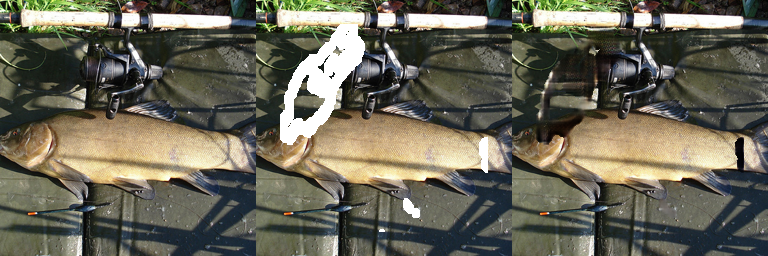

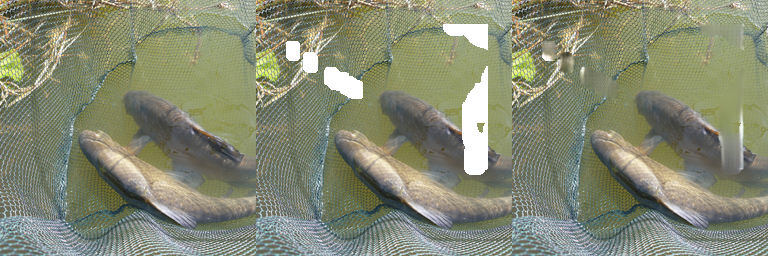

PSNR: 25.808523, MAE: 0.022733646


In [14]:
def stitch_images(inputs, *outputs, img_per_row=2):
    gap = 5
    columns = len(outputs) + 1

    width, height = inputs[0][:, :, 0].shape
    img = Image.new('RGB',
                    (width * img_per_row * columns + gap * (img_per_row - 1), height * int(len(inputs) / img_per_row)))
    images = [inputs, *outputs]

    for ix in range(len(inputs)):
        xoffset = int(ix % img_per_row) * width * columns + int(ix % img_per_row) * gap
        yoffset = int(ix / img_per_row) * height

        for cat in range(len(images)):
            im = images[cat][ix].asnumpy().astype(np.uint8).squeeze()
            im = Image.fromarray(im)
            img.paste(im, (xoffset + cat * width, yoffset))

    return img


from upsample_utils.util import postprocess, imsave

opts.mask_type = 3
opts.mode = 2
opts.input = './input/'
opts.kmeans = './kmeans_centers.npy'
# 确保第二阶段的输入与第一阶段的输出相同
opts.prior = opts.save_url

generator = Generator()
generator.set_train(False)
# 根据相应权重文件进行路径修改，如果进行修改，请注意使用绝对路径避免不必要的错误
opts.ckpt_path = './ckpts_ICT/ms_train/Upsample/InpaintingModel_gen_best.ckpt'
if os.path.exists(opts.ckpt_path):
    print('Start loading the model parameters from %s' % (opts.ckpt_path))
    checkpoint = mindspore.load_checkpoint(opts.ckpt_path)
    mindspore.load_param_into_net(generator, checkpoint)
    print('Finished load the model')

psnr_func = PSNR(255.0)

test_dataset = load_dataset(image_flist=opts.input, edge_flist=opts.prior, mask_filst=opts.mask,
                            image_size=opts.image_size, prior_size=opts.prior_size, mask_type=opts.mask_type,
                            kmeans=opts.kmeans, condition_num=opts.condition_num,
                            augment=False, training=False)

index = 0
psnr = AverageMeter()
mae = AverageMeter()
test_batch_size = 1
test_dataset = test_dataset.batch(test_batch_size)
for sample in test_dataset.create_dict_iterator():
    name = sample['name'].asnumpy()[0]
    images = sample['images']
    edges = sample['edges']
    masks = sample['masks']
    inputs = (images * (1 - masks)) + masks
    index += test_batch_size
    outputs = generator(images, edges, masks)
    outputs_merged = (outputs * masks) + (images * (1 - masks))
    psnr.update(psnr_func(postprocess(images), postprocess(outputs_merged)), 1)
    mae.update((P.ReduceSum()(P.Abs()(images - outputs_merged)) / P.ReduceSum()(images)), 1)
    result_merge = stitch_images(
        postprocess(images),
        postprocess(inputs),
        postprocess(outputs_merged),
        img_per_row=1
    )
    result_merge.show()
    output = postprocess(outputs_merged)[0]
    path = os.path.join(opts.save_url, name[:-4] + "_%d" % (index % opts.condition_num) + '.png')
    imsave(output, path)
print('PSNR: {}, MAE: {}'.format(psnr.avg, mae.avg))


上图为将原图、输入以及结果做了处理后统一输出的结果，第一张图为未被损坏的原图，第二张图则是经过掩码处理后的图片，相当于输入，第三张图是网络的输出，即图像补全的结果。

## 总结

本案例对ICT论文中提出的模型做了相应的解释，展示了模型的训练以及两阶段推理的过程，其中第一阶段利用Transformer产生低分辨率的图像先验信息，第二阶段使用卷积神经网络将低分辨率信息的图片复原到高分辨率，以此结合Transformer和CNN的相应的优势，来完成图像补全任务。

## 引用

[1] Wan Z, Zhang J, Chen D, et al. High-fidelity pluralistic image completion with transformers[C]//Proceedings of the IEEE/CVF International Conference on Computer Vision. 2021: 4692-4701.

[2] Liu G, Reda F A, Shih K J, et al. Image inpainting for irregular holes using partial convolutions[C]//Proceedings of the European conference on computer vision (ECCV). 2018: 85-100.

[3] Simonyan K, Zisserman A. Very deep convolutional networks for large-scale image recognition[J]. arXiv preprint arXiv:1409.1556, 2014.

[4] Radford A, Narasimhan K, Salimans T, et al. Improving language understanding by generative pre-training[J]. 2018.